# 1. Análise Exploratória dos Dados

## 1.1 Origem dos Dados
Os dados utilizados neste trabalho fazem parte do MovieLens, um sistema de recomendação de filmes mantido pelo GroupLens Research, da Universidade de Minnesota. O conjunto específico usado aqui é o MovieLens 32M (ml-32m), disponibilizado publicamente no site oficial:
http://grouplens.org/datasets/

Esse dataset reúne informações sobre filmes e avaliações feitas por usuários da plataforma ao longo de quase três décadas.

## 1.2 Arquivos Utilizados
Para este projeto, serão usados os arquivos:

movies.csv – contém informações dos filmes (ID, título e gêneros).  
ratings.csv – contém avaliações feitas pelos usuários (ID do usuário, ID do filme, nota e timestamp).

Mesmo que existam outros arquivos como tags.csv e links.csv, eles não serão necessários para esta etapa da análise.

## 1.3 Tamanho do Dataset
O dataset completo é bastante grande, contendo:  
32.000.204 avaliações;  
2.000.072 tags;  
87.585 filmes;  
200.948 usuários.
  
Como usaremos apenas movies e ratings, o relevante para nossa análise é:  
**movies.csv**  
87.585 instâncias;  
3 atributos:  
movieId;  
title;  
genres.  
  
**ratings.csv**  
Aproximadamente 32 milhões de instâncias  
4 atributos:  
userId;  
movieId;  
rating;  
timestamp.  

## 1.4 Período Abrangido
O MovieLens 32M inclui avaliações registradas entre 09 de janeiro de 1995 e 12 de outubro de 2023.

Isso significa que o dataset cobre quase 30 anos de atividade de usuários.

## 1.5 Licença de Uso
O MovieLens é disponibilizado para uso acadêmico e de pesquisa, com algumas condições:

O dataset não pode ser utilizado para fins comerciais sem permissão.  
É obrigatório citar a fonte em trabalhos que utilizem os dados.  
Os dados podem ser redistribuídos, desde que sob as mesmas condições da licença original.  
Não há garantias quanto à precisão dos dados.  

## 1.6 Questões Éticas e de Privacidade
Mesmo sendo um dataset amplamente utilizado, é importante destacar algumas considerações éticas:  
  
**O que foi anonimizado**  
Os usuários não possuem nenhuma informação pessoal:  
sem nome, idade, localização, gênero, profissão etc.  
Cada usuário é identificado apenas por um número (userId), gerado especificamente para o dataset.  
  
**Conteúdo sensível**  
Não há conteúdo sensível explícito.  
As avaliações são voluntárias e públicas para pesquisa.  
O dataset é mantido por uma instituição acadêmica, seguindo boas práticas consolidadas.  
  
**Por que é considerado eticamente aceitável**  
Anonimização consistente.  
Sem coleta de dados demográficos.  
Uso permitido apenas para fins não comerciais.  

# 2 Processamentos Realizados nos Dados
Nesta etapa, foram aplicadas diversas verificações e transformações para garantir a integridade e consistência dos dados utilizados.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import re
import squarify

In [96]:
movies = pd.read_csv("../data/movies.csv")
ratings = pd.read_csv("../data/ratings.csv")

In [97]:
print("=== ANÁLISE BÁSICA DO DATASET ===")

print("\n1. PRIMEIRAS LINHAS DE CADA DATASET:")
print("\nMovies dataset:")
print(movies.head(3))
print("\nRatings dataset:")
print(ratings.head(3))

print("\n2. INFORMAÇÕES GERAIS:")
print("\nMovies - Shape:", movies.shape)
print("Ratings - Shape:", ratings.shape)

=== ANÁLISE BÁSICA DO DATASET ===

1. PRIMEIRAS LINHAS DE CADA DATASET:

Movies dataset:
   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  

Ratings dataset:
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976

2. INFORMAÇÕES GERAIS:

Movies - Shape: (87585, 3)
Ratings - Shape: (32000204, 4)


## 2.1 Verificação de dados faltantes

In [98]:
movies.isna().sum(), ratings.isna().sum()

(movieId    0
 title      0
 genres     0
 dtype: int64,
 userId       0
 movieId      0
 rating       0
 timestamp    0
 dtype: int64)

## 2.2 Verificação dos tipos de dados

In [99]:
movies.dtypes, ratings.dtypes

(movieId     int64
 title      object
 genres     object
 dtype: object,
 userId         int64
 movieId        int64
 rating       float64
 timestamp      int64
 dtype: object)

## 2.3 Verificação de Duplicatas

In [100]:
movies.duplicated(subset=["movieId"]).sum(), ratings.duplicated().sum()

(np.int64(0), np.int64(0))

## 2.4 Consistência interna
Valida se todos os movieId presentes em ratings.csv também existiem em movies.csv.

In [101]:
ids_movies = set(movies['movieId'])
ids_ratings = set(ratings['movieId'])

ids_invalidos = ids_ratings - ids_movies
len(ids_invalidos)

0

## 2.5 Análise de valores fora do domínio

In [102]:
values = sorted(ratings['rating'].unique())
values = [float(v) for v in values]
print(values)

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


## 2.6 Análise de outliers

In [103]:
ratings['rating'].value_counts().sort_index()

rating
0.5     525132
1.0     946675
1.5     531063
2.0    2028622
2.5    1685386
3.0    6054990
3.5    4290105
4.0    8367654
4.5    2974000
5.0    4596577
Name: count, dtype: int64

In [104]:
ratings['userId'].value_counts().describe()

count    200948.000000
mean        159.246193
std         282.025462
min          20.000000
25%          36.000000
50%          73.000000
75%         167.000000
max       33332.000000
Name: count, dtype: float64

## 2.7 Amostragem para redução do conjunto

**Amostragem do ratings.csv**
Como o arquivo ratings.csv contém mais de 32 milhões de registros, foi realizada uma amostragem estratificada por usuário, preservando a distribuição real de avaliações.

Amostragem aplicada:
10% das avaliações de cada usuário.

Essa técnica evita vieses que poderiam surgir ao selecionar registros aleatórios globalmente ou ao limitar por quantidade de linhas.

In [105]:
sample_frac = 0.10

def stratified_sample_ratings(path, sample_frac=0.10, chunksize=5_000_000):
    sampled_chunks = []
    reader = pd.read_csv(path, chunksize=chunksize)
    for chunk in reader:
        sampled = (chunk.groupby('userId', group_keys=False)
                        .apply(lambda g: g.sample(frac=sample_frac, random_state=42)))
        sampled_chunks.append(sampled)
    sampled_df = pd.concat(sampled_chunks, ignore_index=True)
    return sampled_df

ratings_sample = stratified_sample_ratings("../data/ratings.csv", sample_frac=0.10)

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\2690727779.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=sample_frac, random_state=42)))
C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\2690727779.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=sample_frac, random_state=42)))
C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\2690727779.py:8: Futu

In [106]:
print(f"Dataset original: {len(ratings):,} avaliações")
print(f"Dataset amostrado: {len(ratings_sample):,} avaliações")
print(f"Usuários originais: {ratings['userId'].nunique()}")
print(f"Usuários na amostra: {ratings_sample['userId'].nunique()}")

Dataset original: 32,000,204 avaliações
Dataset amostrado: 3,197,329 avaliações
Usuários originais: 200948
Usuários na amostra: 200948


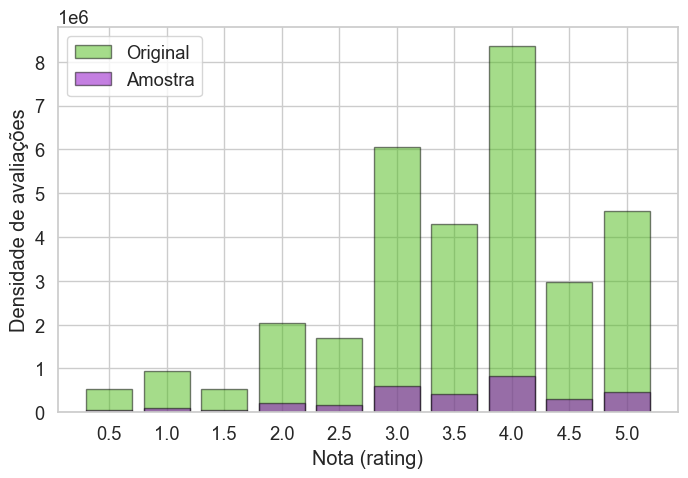

In [107]:
plt.figure(figsize=(8,5))
bins = np.arange(0.25, 5.50, 0.5)

ratings['rating'].hist(
    bins=bins,
    alpha=0.5,
    label='Original',
    color='#4cbb17',
    edgecolor='black',
    rwidth=0.8
    
)

ratings_sample['rating'].hist(
    bins=bins,
    alpha=0.5,
    label='Amostra',
    color='#8a00c4',
    edgecolor='black',
    rwidth=0.8
)

plt.xlabel("Nota (rating)")
plt.ylabel("Densidade de avaliações")
plt.xticks(np.arange(0.5, 5.1, 0.5))
plt.legend()
plt.show()

In [108]:
import numpy as np

for i in np.arange(1, 5.5, 0.5):
    count = ratings_sample['rating'].eq(i).sum()
    print(i, count)


1.0 94981
1.5 52891
2.0 201789
2.5 167841
3.0 603196
3.5 426857
4.0 836926
4.5 298525
5.0 462098


## 2.8 Feature engineering (atributos derivados importantes)

In [109]:
ratings = ratings_sample

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

ratings['year'] = ratings['timestamp'].dt.year
ratings['month'] = ratings['timestamp'].dt.to_period('M').dt.to_timestamp()

movie_stats = ratings.groupby('movieId')['rating'].agg(
    movie_rating_count='count',
    movie_rating_mean='mean',
    movie_rating_std='std'
).reset_index()

user_stats = ratings.groupby('userId')['rating'].agg(
    user_rating_count='count',
    user_rating_mean='mean',
    user_rating_std='std'
).reset_index()

movies = movies.merge(movie_stats, on='movieId', how='left')

def extract_year(title):
    m = re.search(r'\((\d{4})\)\s*$', str(title))
    if m:
        return int(m.group(1))
    else:
        return np.nan
        

movies['release_year'] = movies['title'].apply(extract_year)

movies['genres_list'] = movies['genres'].str.split('|').apply(lambda x: x if isinstance(x, list) else [])
movies_exploded = movies.explode('genres_list').rename(columns={'genres_list':'genre'})

# 3. Estatísticas descritivas e distribuições

## 3.1 Estatísticas básicas (rating, counts)

In [110]:
print("Ratings (global):")
print(ratings['rating'].describe())

print("\nMovie rating counts:")
print(movie_stats['movie_rating_count'].describe())

print("\nUser rating counts:")
print(user_stats['user_rating_count'].describe())

Ratings (global):
count    3.197329e+06
mean     3.543193e+00
std      1.059540e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Movie rating counts:
count    42425.000000
mean        75.364266
std        373.455055
min          1.000000
25%          1.000000
50%          3.000000
75%         14.000000
max      17463.000000
Name: movie_rating_count, dtype: float64

User rating counts:
count    200948.000000
mean         15.911226
std          28.210490
min           2.000000
25%           4.000000
50%           7.000000
75%          17.000000
max        3333.000000
Name: user_rating_count, dtype: float64


## 3.2 Distribuição dos ratings (histograma)

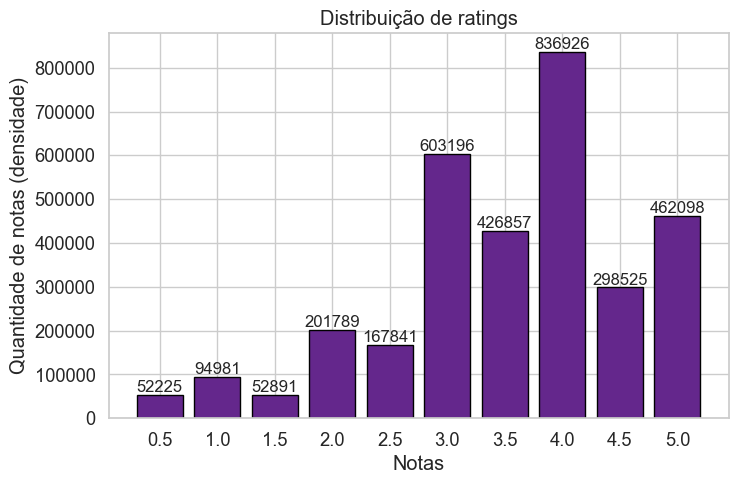

In [111]:
plt.figure(figsize=(8,5))

bins = np.arange(0.25, 5.50, 0.5)

counts, bin_edges, patches = plt.hist(
    ratings['rating'], 
    bins=bins, 
    rwidth=0.8, 
    edgecolor='black', 
    color="#64278C"
)

for count, patch in zip(counts, patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()         
    plt.text(x, y, int(count), ha='center', va='bottom', fontsize=12)

plt.xlabel('Notas')
plt.ylabel('Quantidade de notas (densidade)')
plt.title('Distribuição de ratings')
plt.xticks(np.arange(0.5, 5.1, 0.5))
plt.show()


## 3.3 Distribuição de avaliações por filme e por usuário (log-scale)

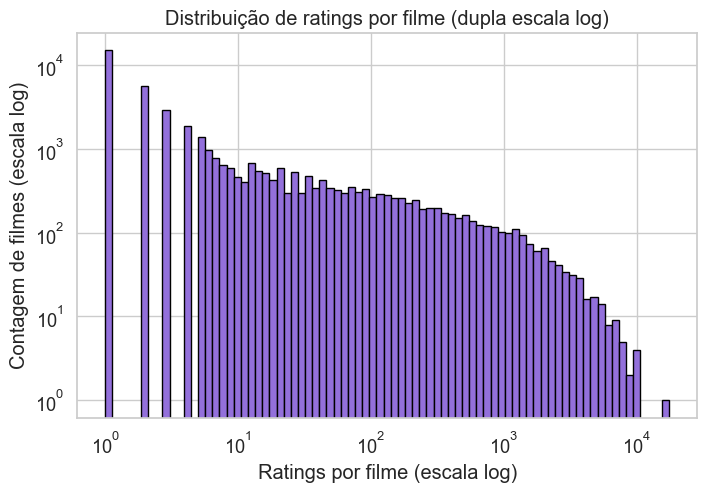

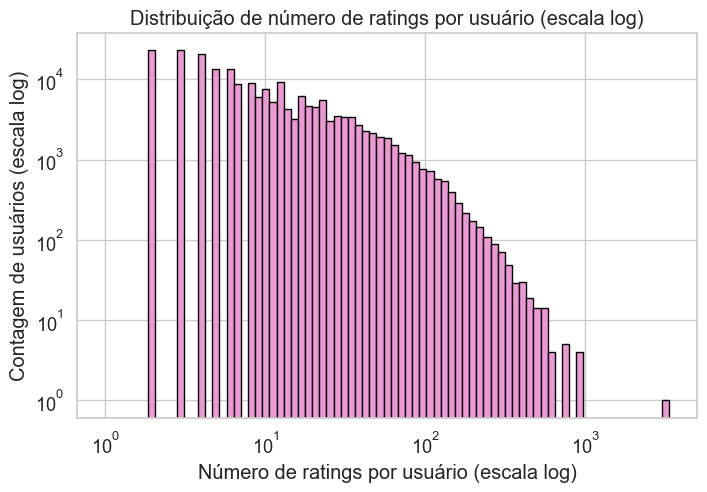

In [112]:
plt.figure(figsize=(8,5))

plt.hist(movie_stats['movie_rating_count'].clip(1), 
         bins=np.logspace(0, np.log10(movie_stats['movie_rating_count'].max()), 80),
         color="mediumpurple", edgecolor='black')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Ratings por filme (escala log)')
plt.ylabel('Contagem de filmes (escala log)')
plt.title('Distribuição de ratings por filme (dupla escala log)')
plt.show()

plt.figure(figsize=(8,5))

plt.hist(
    user_stats['user_rating_count'].clip(1),
    bins=np.logspace(0, np.log10(user_stats['user_rating_count'].max()), 80),
    edgecolor='black',
    color="#eb98d5"
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Número de ratings por usuário (escala log)')
plt.ylabel('Contagem de usuários (escala log)')
plt.title('Distribuição de número de ratings por usuário (escala log)')
plt.show()


## 3.4 Análises por gênero

**Top gêneros por número de filmes e média de nota**

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\3790933993.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


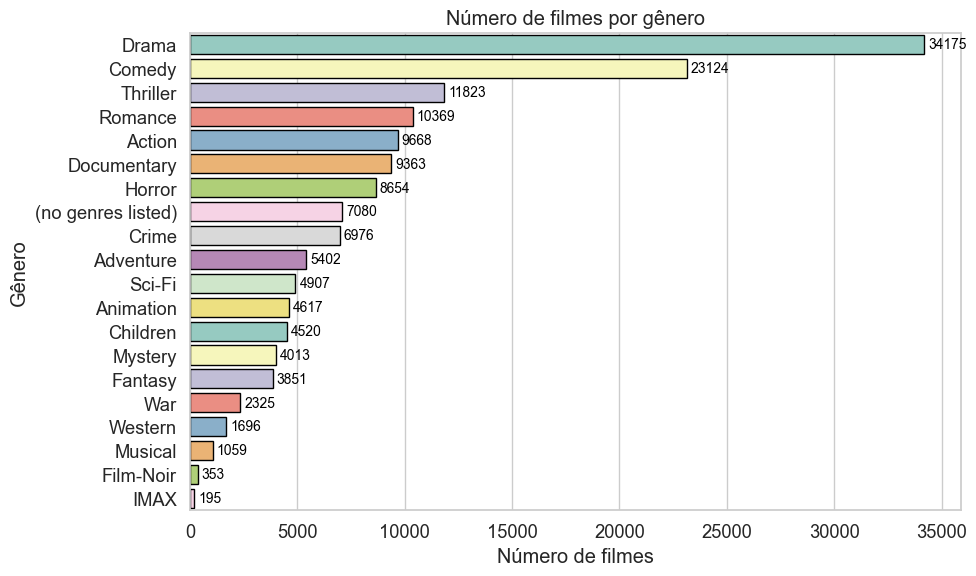

In [114]:
genre_counts = movies_exploded.groupby('genre')['movieId'].nunique().sort_values(ascending=False)
genre_rating = movies_exploded.groupby('genre')['movie_rating_mean'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=genre_counts.values, 
    y=genre_counts.index, 
    edgecolor='black', 
    palette='Set3'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, color='black', fontsize=10)

plt.xlabel('Número de filmes')
plt.ylabel('Gênero')
plt.title('Número de filmes por gênero')
plt.tight_layout()
plt.show()


**Boxplot de ratings por gênero (só gêneros com N filmes mínimos)**

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\3508711192.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


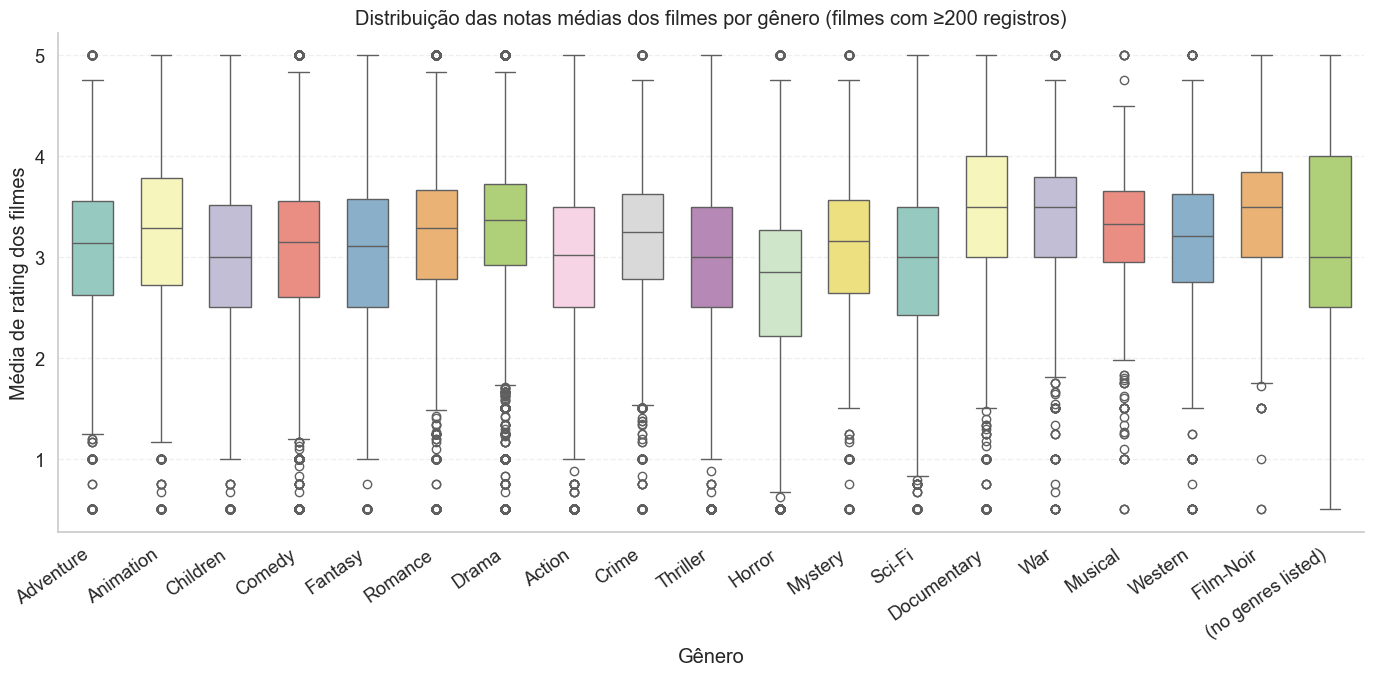

In [115]:

min_movies = 200
popular_genres = genre_counts[genre_counts >= min_movies].index.tolist()
df_plot = movies_exploded[movies_exploded['genre'].isin(popular_genres)].copy()

df_plot = df_plot.dropna(subset=['movie_rating_mean'])

plt.figure(figsize=(14,7))

sns.boxplot(
    data=df_plot,
    x='genre',
    y='movie_rating_mean',
    palette='Set3',
    width=0.6,     
)

sns.despine()

plt.xticks(rotation=35, ha='right')
plt.xlabel("Gênero")
plt.ylabel("Média de rating dos filmes")
plt.title("Distribuição das notas médias dos filmes por gênero (filmes com ≥200 registros)")

plt.grid(axis='y', alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## 3.5 Relações temporais (séries temporais)

**Evolução do número de ratings por ano**

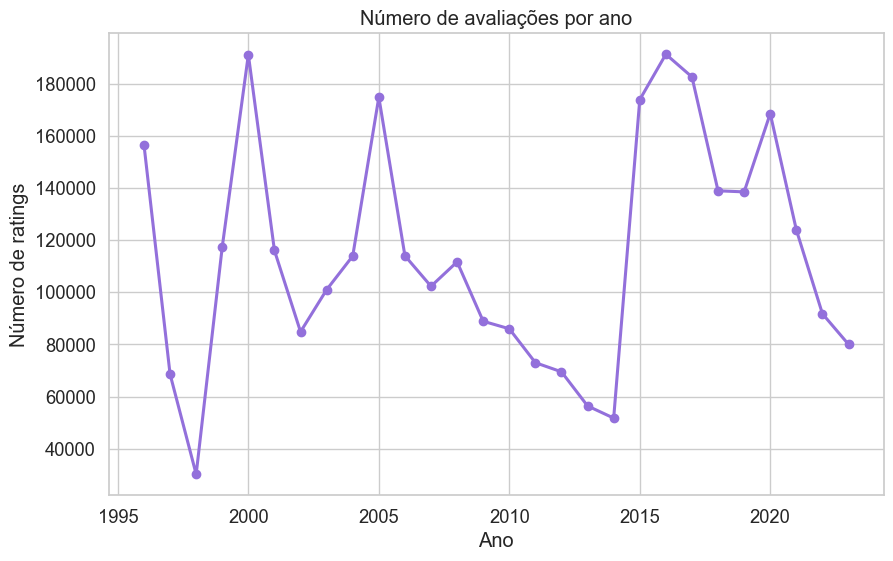

In [116]:

ratings_per_year = ratings.groupby('year').size()
ratings_per_month = ratings.groupby('month').size()

plt.figure(figsize=(10,6))
ratings_per_year.plot(marker='o', linewidth=2.2, color='mediumpurple')
plt.xlabel('Ano')
plt.ylabel('Número de ratings')
plt.title('Número de avaliações por ano')
plt.show()

**Evolução da média de rating ao longo do tempo (mês)**

In [117]:
ratings_per_year = ratings.groupby('year')['rating'].count()

top_year = ratings_per_year.idxmax()
print(top_year)

ratings_top_year = ratings[ratings['year'] == top_year]
mean_rating_by_month_top_year = (
    ratings_top_year
        .groupby('month')['rating']
        .mean()
)

2016


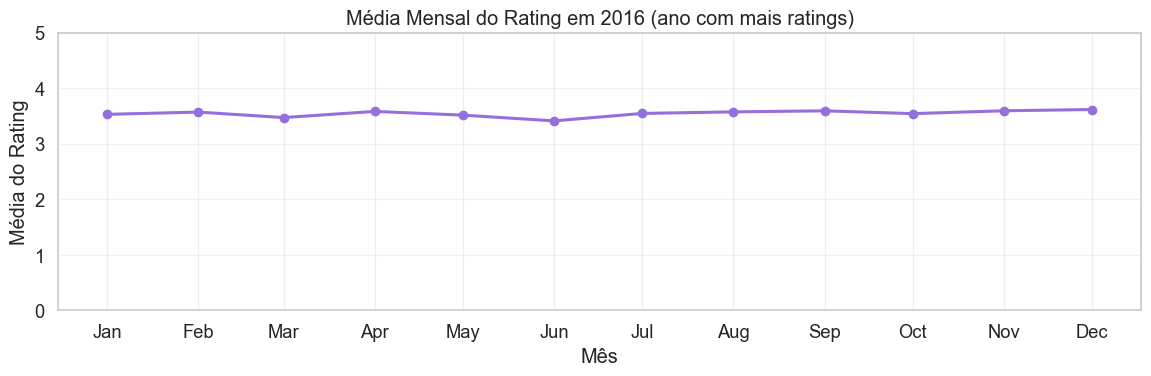

In [118]:
import matplotlib.dates as mdates

sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(12,4))
plt.plot(mean_rating_by_month_top_year.index, 
         mean_rating_by_month_top_year.values,
         marker='o', linewidth=2.2, color='mediumpurple')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xlabel('Mês')
plt.ylabel('Média do Rating')
plt.title(f'Média Mensal do Rating em {top_year} (ano com mais ratings)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.ylim(0, 5)
plt.show()


In [119]:
mean_rating_by_month_top_year

month
2016-01-01    3.527118
2016-02-01    3.567891
2016-03-01    3.468904
2016-04-01    3.580024
2016-05-01    3.512584
2016-06-01    3.409397
2016-07-01    3.543652
2016-08-01    3.571640
2016-09-01    3.590340
2016-10-01    3.539962
2016-11-01    3.591363
2016-12-01    3.613666
Name: rating, dtype: float64

In [120]:
print(ratings.columns)

Index(['userId', 'movieId', 'rating', 'timestamp', 'year', 'month'], dtype='object')


**Relação entre Ano de Lançamento e Quantidade de Filmes**

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\1397471296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_years['release_year'] = movies_years['release_year'].astype(int)


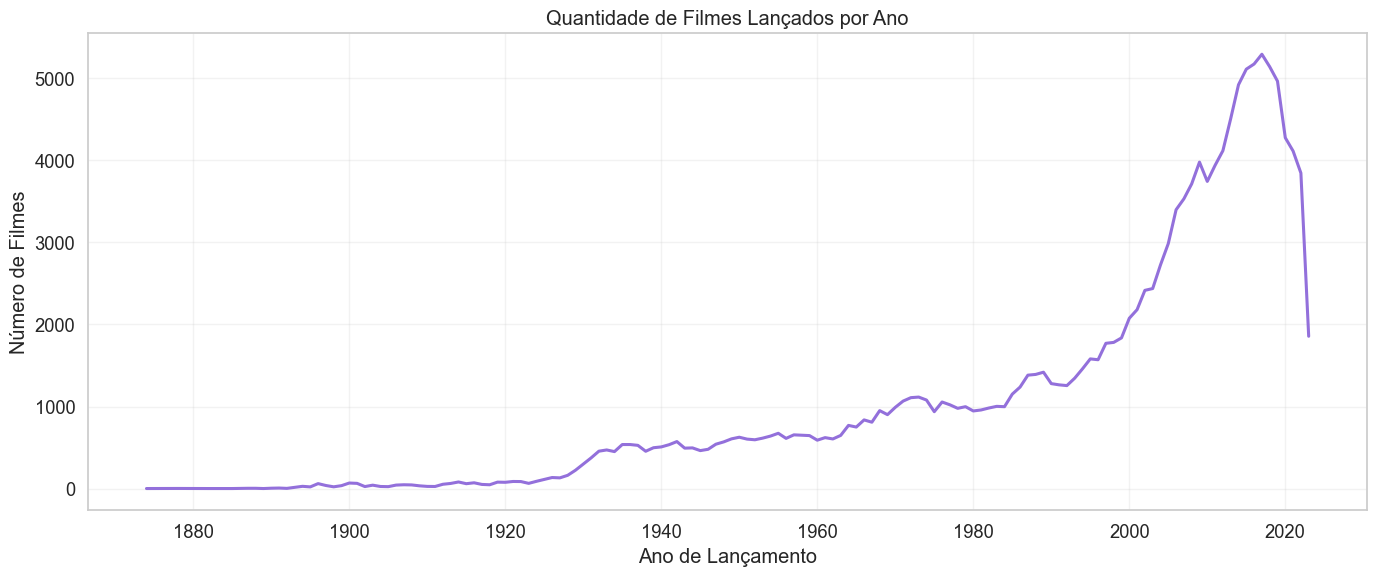

In [121]:
movies_years = movies_exploded.dropna(subset=['release_year'])
movies_years['release_year'] = movies_years['release_year'].astype(int)

films_per_year = (
    movies_years.groupby('release_year')
    .size()
    .reset_index(name='film_count')
)

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=films_per_year,
    x='release_year',
    y='film_count',
    color="mediumpurple",
    linewidth=2.2
)

plt.title("Quantidade de Filmes Lançados por Ano")
plt.xlabel("Ano de Lançamento")
plt.ylabel("Número de Filmes")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\3080698193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_years['release_year'] = movies_years['release_year'].astype(int)


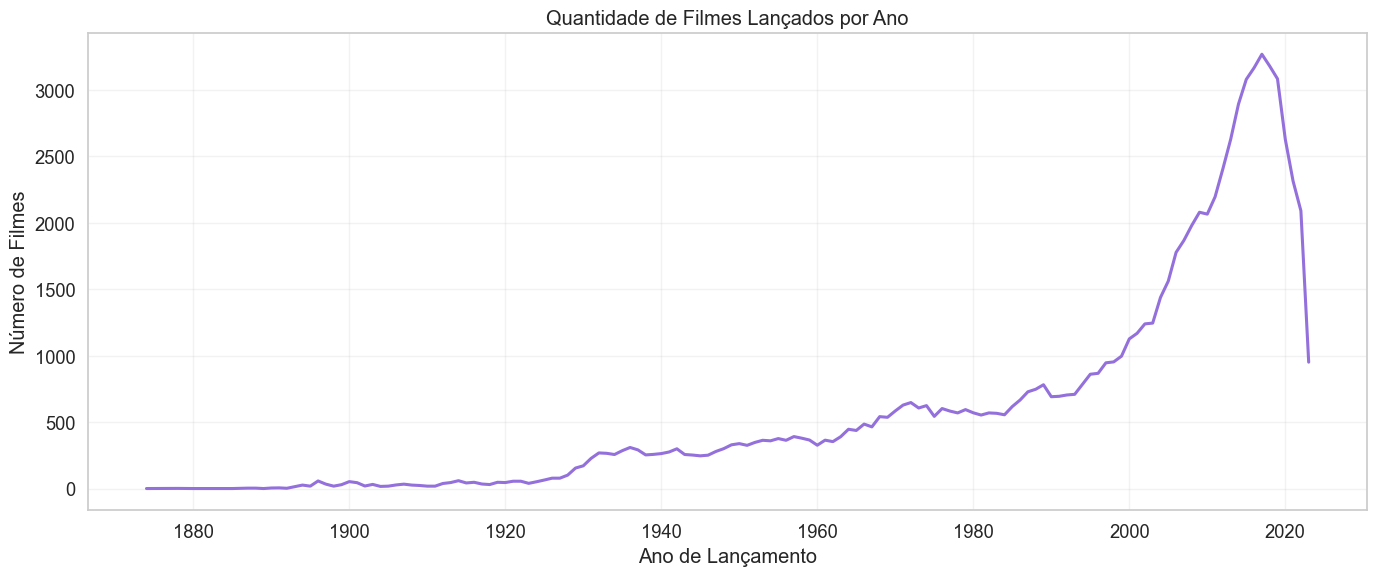

In [122]:
movies_years = movies.dropna(subset=['release_year'])
movies_years['release_year'] = movies_years['release_year'].astype(int)

films_per_year = (
    movies_years.groupby('release_year')
    .size()
    .reset_index(name='film_count')
)

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=films_per_year,
    x='release_year',
    y='film_count',
    color="mediumpurple",
    linewidth=2.2
)

plt.title("Quantidade de Filmes Lançados por Ano")
plt.xlabel("Ano de Lançamento")
plt.ylabel("Número de Filmes")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

## 3.6 Correlações entre atributos derivados
Criamos um DataFrame com features numéricas e rodamos correlação (Pearson e Spearman):

Pearson:
                     movie_rating_mean  movie_rating_count  release_year
movie_rating_mean            1.000000            0.102067     -0.042638
movie_rating_count           0.102067            1.000000     -0.009930
release_year                -0.042638           -0.009930      1.000000

Spearman:
                     movie_rating_mean  movie_rating_count  release_year
movie_rating_mean            1.000000            0.136611     -0.041289
movie_rating_count           0.136611            1.000000     -0.101142
release_year                -0.041289           -0.101142      1.000000


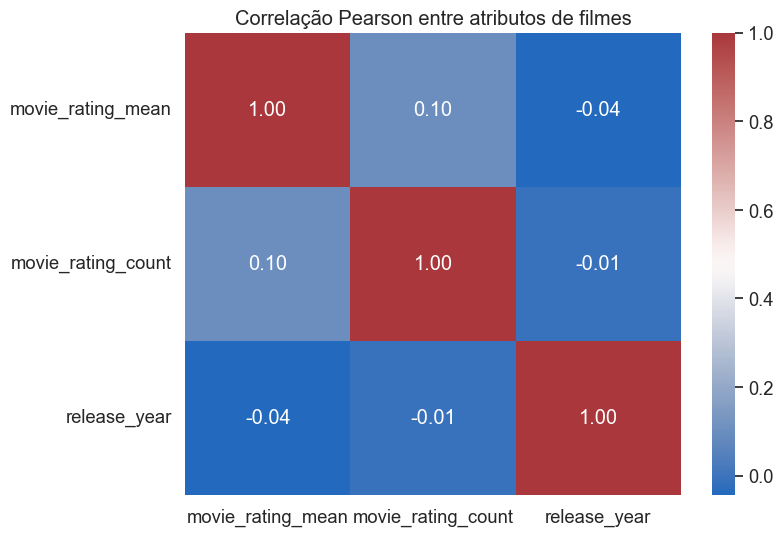

In [123]:
movie_corr_df = movies[['movieId', 'movie_rating_count', 'movie_rating_mean', 'release_year']].copy()

corr_pearson = movie_corr_df[['movie_rating_mean','movie_rating_count', 'release_year']].corr(method='pearson')
corr_spearman = movie_corr_df[['movie_rating_mean','movie_rating_count','release_year']].corr(method='spearman')

print("Pearson:\n", corr_pearson)
print("\nSpearman:\n", corr_spearman)

plt.figure(figsize=(8,6))
sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap='vlag')
plt.title('Correlação Pearson entre atributos de filmes')
plt.show()

## 3.7 Verificações finais de qualidade (checklist automatizado)

In [124]:
def quality_checks(movies, ratings):
    checks = {}
    checks['movies_nulls'] = movies.isnull().sum()
    checks['ratings_nulls'] = ratings.isnull().sum()
    checks['movieId_in_ratings_not_in_movies'] = len(set(ratings['movieId']) - set(movies['movieId']))
    checks['rating_min_max'] = (ratings['rating'].min(), ratings['rating'].max())
    checks['unique_users'] = ratings['userId'].nunique()
    checks['unique_movies'] = ratings['movieId'].nunique()
    return checks

qc = quality_checks(movies, ratings)
qc

{'movies_nulls': movieId                   0
 title                     0
 genres                    0
 movie_rating_count    45160
 movie_rating_mean     45160
 movie_rating_std      60333
 release_year            617
 genres_list               0
 dtype: int64,
 'ratings_nulls': userId       0
 movieId      0
 rating       0
 timestamp    0
 year         0
 month        0
 dtype: int64,
 'movieId_in_ratings_not_in_movies': 0,
 'rating_min_max': (np.float64(0.5), np.float64(5.0)),
 'unique_users': 200948,
 'unique_movies': 42425}

# 4. PERGUNTAS

**1. Quais filmes têm mais avaliações (populares)?**    

Por quê?  
Identificar os filmes mais avaliados ajuda a entender quais títulos atraem mais atenção do público, permitindo priorizar recomendações e analisar o impacto da popularidade sobre as notas.

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\3754716475.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=popularidade.values, y=popularidade.index, edgecolor='black', palette='Set3')


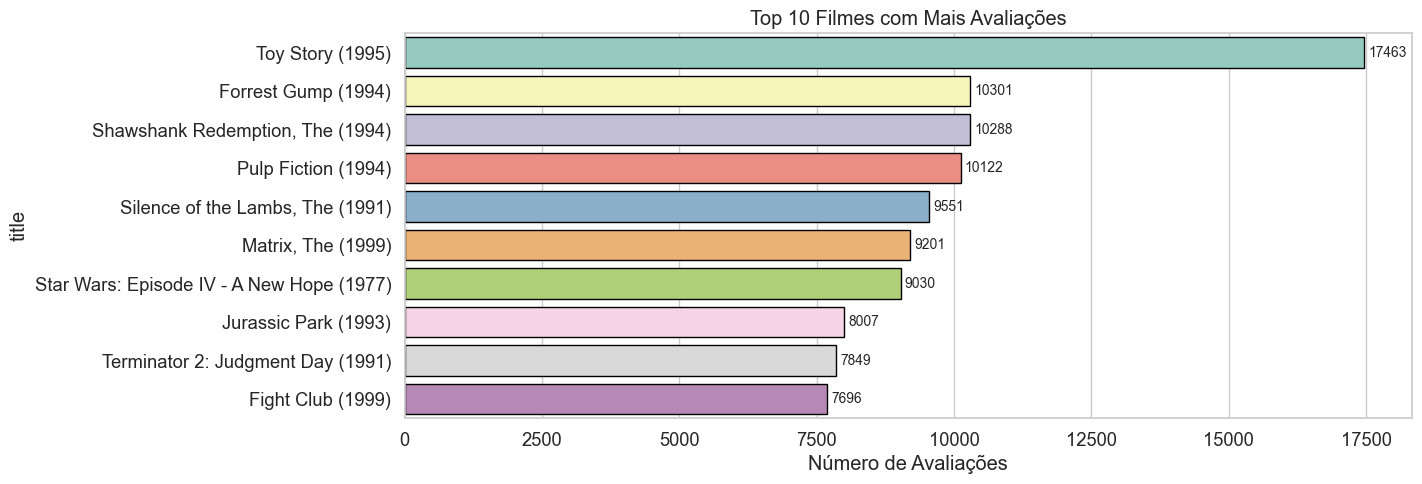

In [125]:
ratings_with_titles = ratings.merge(movies[['movieId', 'title']], on='movieId', how='left')

media_por_filme = (
    ratings_with_titles.groupby("title")["rating"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

popularidade = ratings_with_titles["title"].value_counts().head(10)

plt.figure(figsize=(13,5))
ax = sns.barplot(x=popularidade.values, y=popularidade.index, edgecolor='black', palette='Set3')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=10)

plt.title("Top 10 Filmes com Mais Avaliações")
plt.xlabel("Número de Avaliações")
plt.show()

**2. Como se distribuem as notas ao longo dos anos de lançamento dos filmes?**  

Por quê?  
Permite avaliar tendências históricas de avaliação, identificar se filmes antigos ou recentes tendem a receber notas diferentes e entender possíveis enviesamentos temporais no dataset.

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\2502703063.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


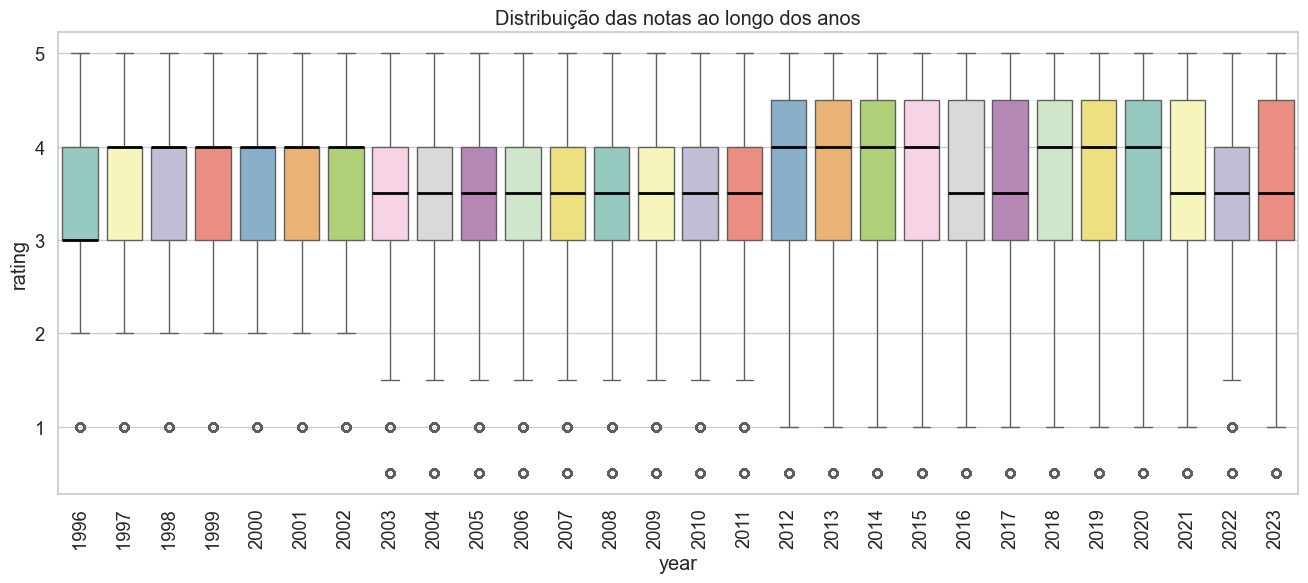

In [127]:
plt.figure(figsize=(16,6))

sns.boxplot(
    data=ratings,
    x="year",
    y="rating",
    palette='Set3',
    medianprops=dict(color="black", linewidth=2)
)

plt.xticks(rotation=90)
plt.title("Distribuição das notas ao longo dos anos")
plt.show()


**3. Quais gêneros são mais populares?**  
  
Por quê?  
Compreender a popularidade de cada gênero ajuda a direcionar estratégias de marketing, seleção de catálogo e análise de comportamento do público, mostrando quais tipos de filmes atraem mais espectadores.

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\825926446.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_popularity.values, y=genre_popularity.index, palette='Set3', edgecolor='black')


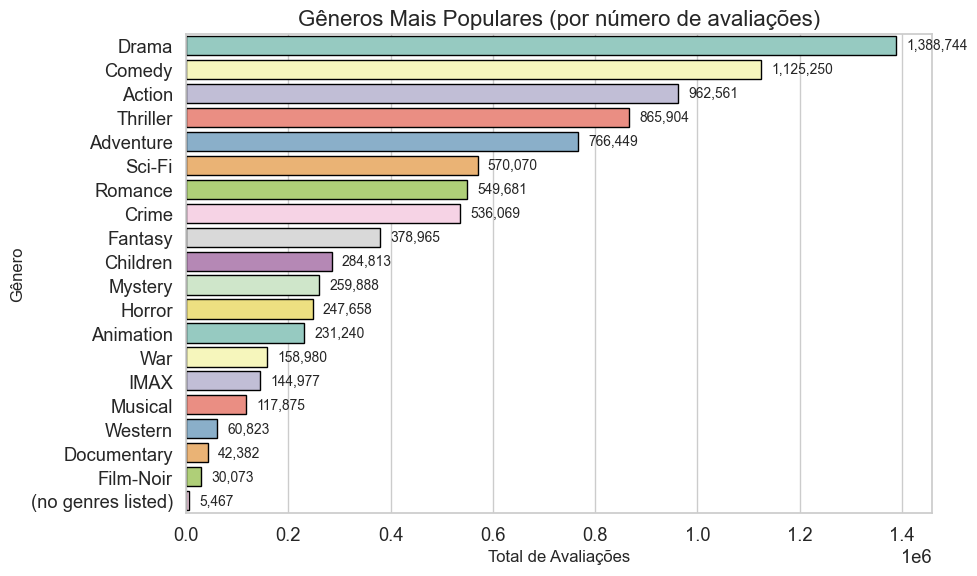

In [129]:
genre_popularity = movies_exploded.groupby('genre')['movie_rating_count'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=genre_popularity.values, y=genre_popularity.index, palette='Set3', edgecolor='black')

plt.title("Gêneros Mais Populares (por número de avaliações)", fontsize=16)
plt.xlabel("Total de Avaliações", fontsize=12)
plt.ylabel("Gênero", fontsize=12)

for i, v in enumerate(genre_popularity.values):
    plt.text(v + 20000, i, f"{int(v):,}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

**4. Quais gêneros apresentam as maiores e menores notas médias? Existem gêneros consistentemente mais bem avaliados?**  
  
Por quê?  
Permite prever tendências de mercado e entender preferências gerais do público, auxiliando decisões de catálogo.

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\3679665797.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_genre_ratings.values, y=df_genre_ratings.index, palette="Set3", edgecolor='black')


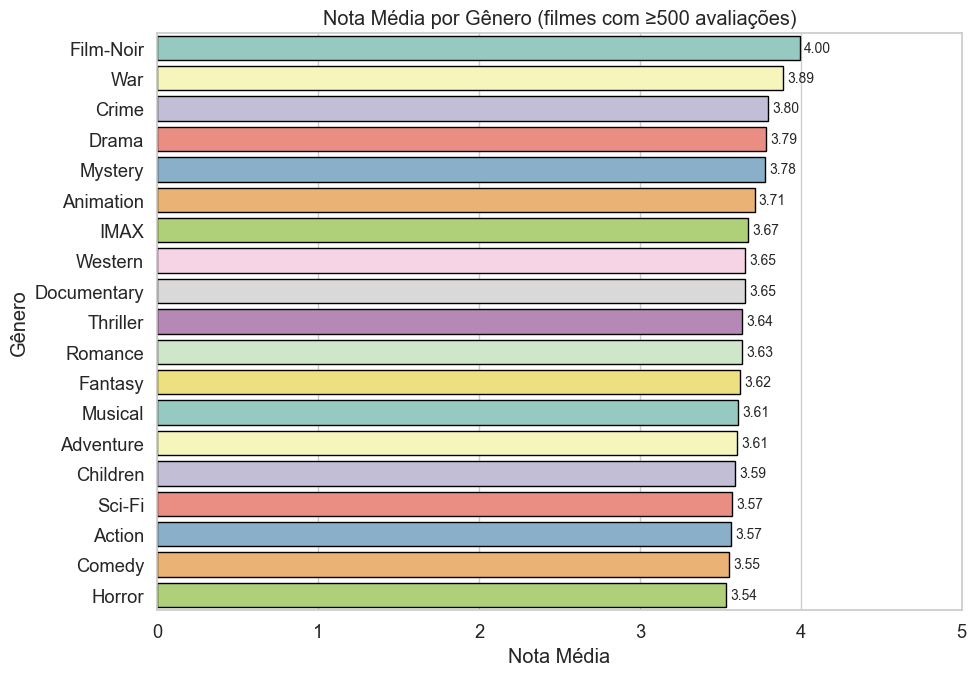

In [130]:
filmes_validos = ratings.groupby('movieId')['rating'].count()
filmes_validos = filmes_validos[filmes_validos >= 500].index

df_genre_ratings = (
    ratings[ratings['movieId'].isin(filmes_validos)]
    .merge(movies_exploded[['movieId','genre']], on='movieId')
    .groupby('genre')['rating']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,7))
ax = sns.barplot(x=df_genre_ratings.values, y=df_genre_ratings.index, palette="Set3", edgecolor='black')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=10)

plt.title("Nota Média por Gênero (filmes com ≥500 avaliações)")
plt.xlabel("Nota Média")
plt.ylabel("Gênero")
plt.xlim(0, 5)
plt.tight_layout()
plt.show()

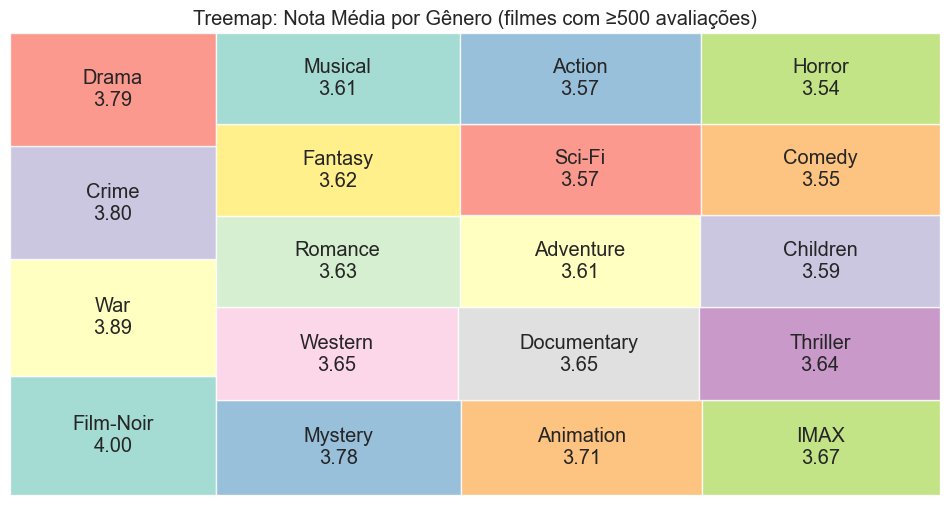

In [131]:
filmes_validos = ratings.groupby('movieId')['rating'].count()
filmes_validos = filmes_validos[filmes_validos >= 500].index

df_genre_ratings = (
    ratings[ratings['movieId'].isin(filmes_validos)]
    .merge(movies_exploded[['movieId','genre']], on='movieId')
    .groupby('genre')['rating']
    .mean()
)

df_genre_ratings = df_genre_ratings.sort_values(ascending=False)

sizes = df_genre_ratings.values

labels = [f"{g}\n{v:.2f}" for g, v in zip(df_genre_ratings.index, df_genre_ratings.values)]

plt.figure(figsize=(12,6))
squarify.plot(
    sizes=sizes,
    label=labels,
    color=sns.color_palette('Set3', len(sizes)),
    alpha=0.8
)
plt.axis('off')
plt.title("Treemap: Nota Média por Gênero (filmes com ≥500 avaliações)")
plt.show()


**5. A popularidade dos filmes (quantidade de avaliações) tem relação com a qualidade percebida (nota média)?**  
  
Por quê?  
Esclarece se os filmes mais vistos são realmente considerados melhores — ótimo para empresas de streaming priorizarem promoções.

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\3737996333.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_bin = filme_stats.groupby('pop_bin')['mean'].mean()


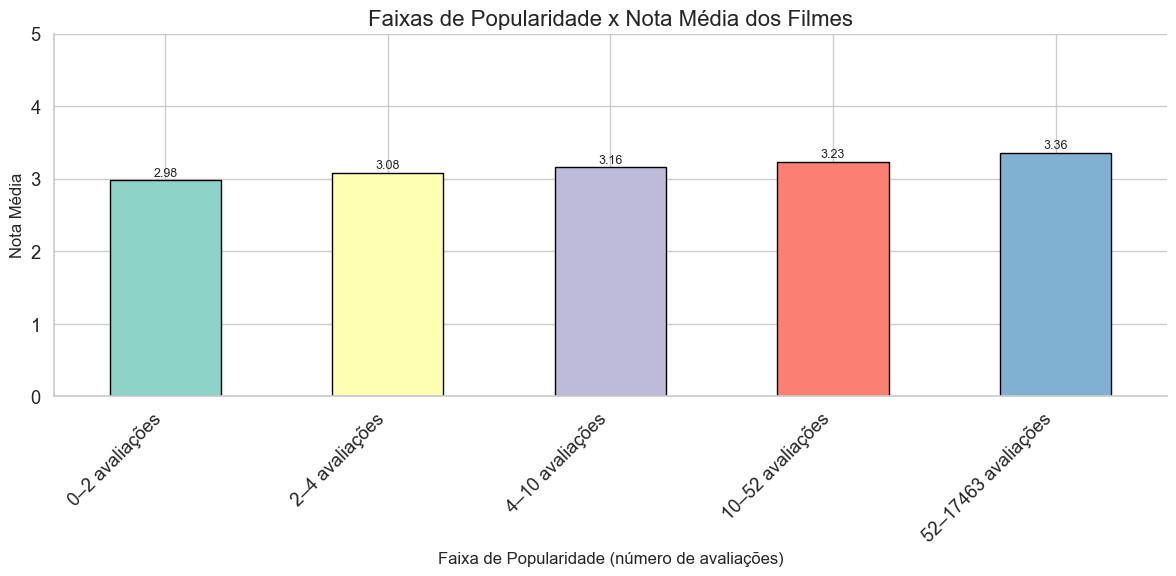

In [132]:
filme_stats = ratings.groupby('movieId')['rating'].agg(['mean','count']).reset_index()

filme_stats['pop_bin'] = pd.qcut(filme_stats['count'], q=7, duplicates='drop')

mean_by_bin = filme_stats.groupby('pop_bin')['mean'].mean()

x_labels = [f"{int(interval.left)}–{int(interval.right)} avaliações" for interval in mean_by_bin.index]

colors = sns.color_palette("Set3", len(mean_by_bin))

plt.figure(figsize=(12,6))
ax = mean_by_bin.plot(kind='bar', color=colors, edgecolor='black')

ax.set_xticklabels(x_labels, rotation=45, ha='right')

for i, v in enumerate(mean_by_bin):
    ax.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

plt.title("Faixas de Popularidade x Nota Média dos Filmes", fontsize=16)
plt.ylabel("Nota Média", fontsize=12)
plt.xlabel("Faixa de Popularidade (número de avaliações)", fontsize=12)
plt.ylim(0, 5)

sns.despine()
plt.tight_layout()
plt.show()

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\282065774.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_by_bin = filme_stats.groupby('pop_bin')['movieId'].count()


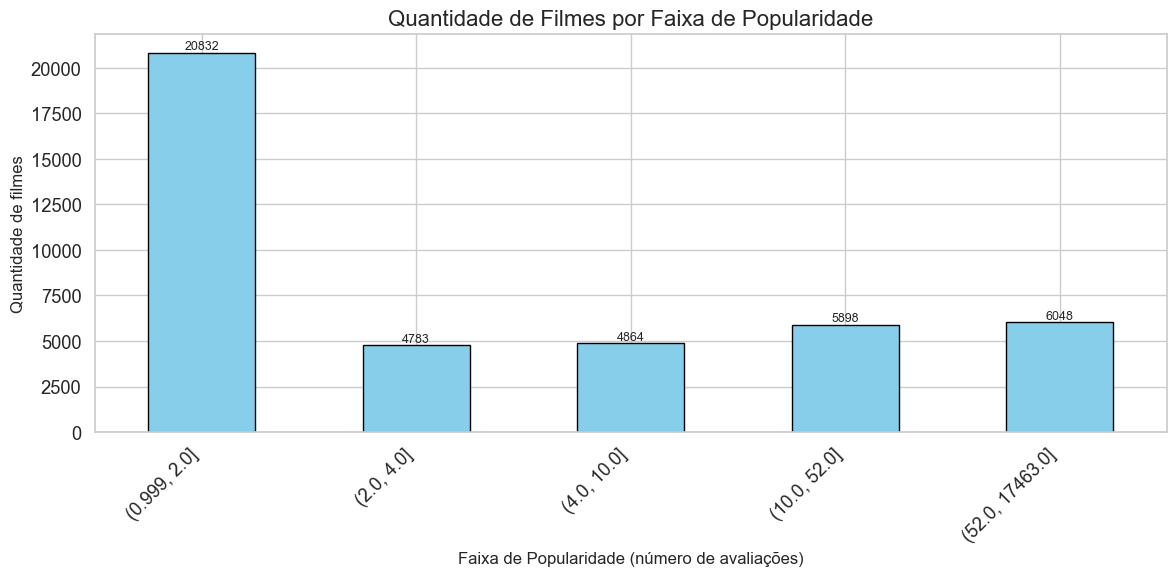

In [133]:
filme_stats['pop_bin']
count_by_bin = filme_stats.groupby('pop_bin')['movieId'].count()

plt.figure(figsize=(12,6))
ax = count_by_bin.plot(kind='bar', color='skyblue', edgecolor='black')

ax.set_ylabel("Quantidade de filmes", fontsize=12)
ax.set_xlabel("Faixa de Popularidade (número de avaliações)", fontsize=12)
ax.set_title("Quantidade de Filmes por Faixa de Popularidade", fontsize=16)

for i, v in enumerate(count_by_bin):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**6. A média das avaliações varia com o ano de lançamento do filme? A indústria está produzindo filmes mais bem avaliados ao longo do tempo?**

Por quê?
Indica evolução percebida da qualidade cinematográfica e ajuda produtoras a entender padrões históricos.

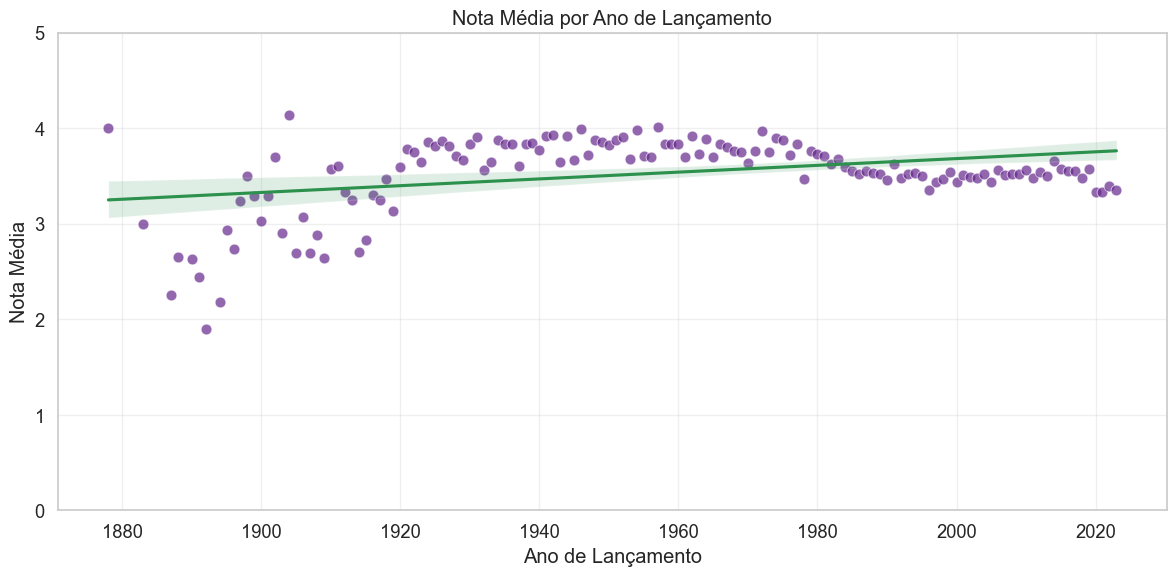

In [134]:
df_year_rating = (
    ratings.merge(movies[['movieId','release_year']], on='movieId')
    .groupby('release_year')['rating']
    .mean()
    .reset_index()
)

plt.figure(figsize=(12,6))

sns.scatterplot(
    data=df_year_rating,
    x='release_year',
    y='rating',
    s=60,
    color="#64278C",
    alpha=0.7
)

sns.regplot(
    data=df_year_rating,
    x='release_year',
    y='rating',
    scatter=False,
    color='#2D914E',
)

plt.title("Nota Média por Ano de Lançamento")
plt.xlabel("Ano de Lançamento")
plt.ylabel("Nota Média")
plt.ylim(0,5)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**7. Quais filmes apresentam maior consenso ou maior discordância entre os usuários (baixa vs. alta variabilidade das notas)?**

Por quê?
Descobrir obras "universais" e obras "polêmicas" é valioso para estratégias de marketing e recomendações personalizadas.

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\763076837.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_disc, y='title', x='std', edgecolor='black', palette='Set3')


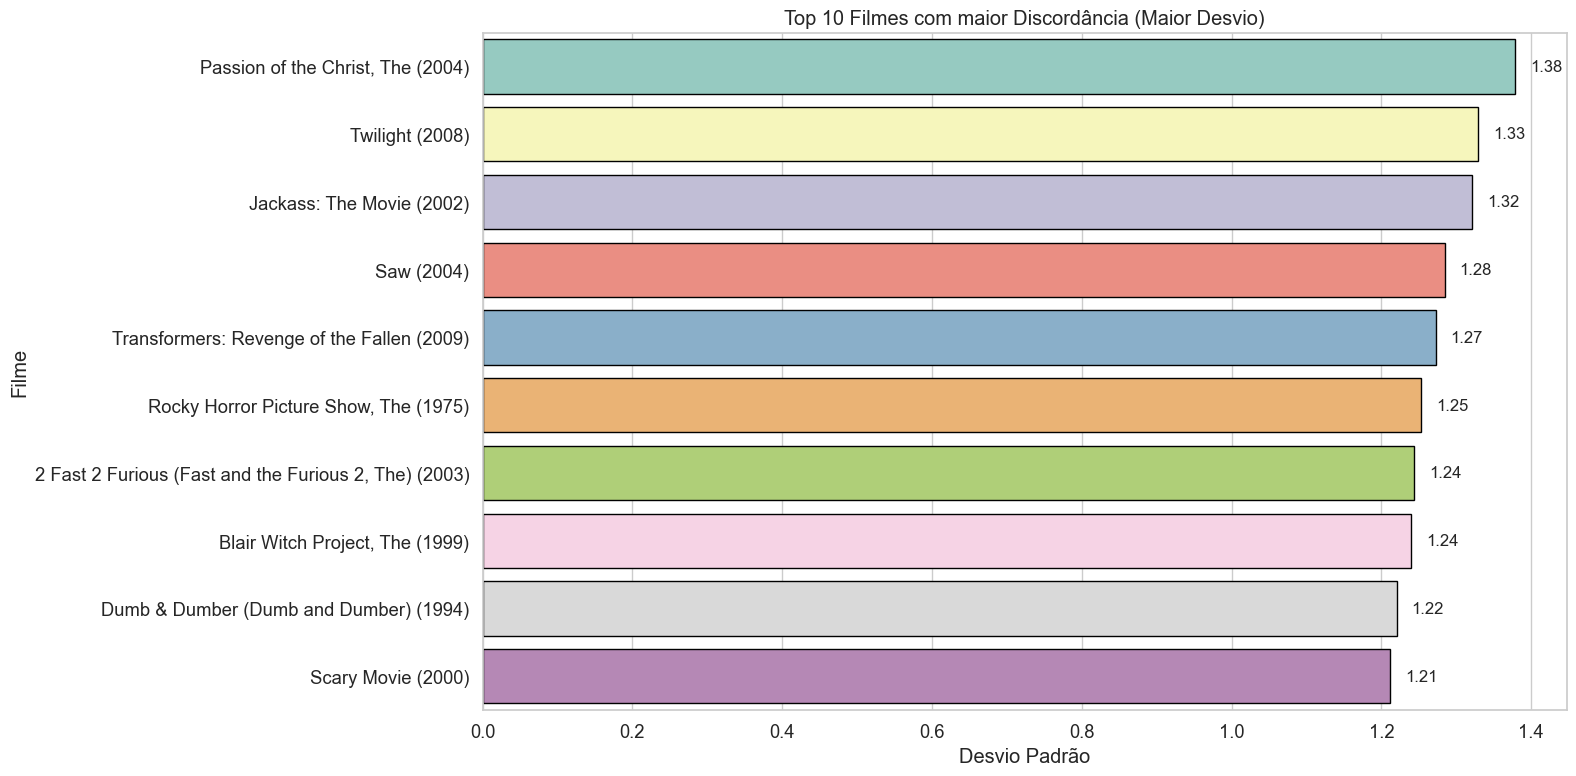

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\763076837.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_cons, y='title', x='std', edgecolor='black', palette='Set3')


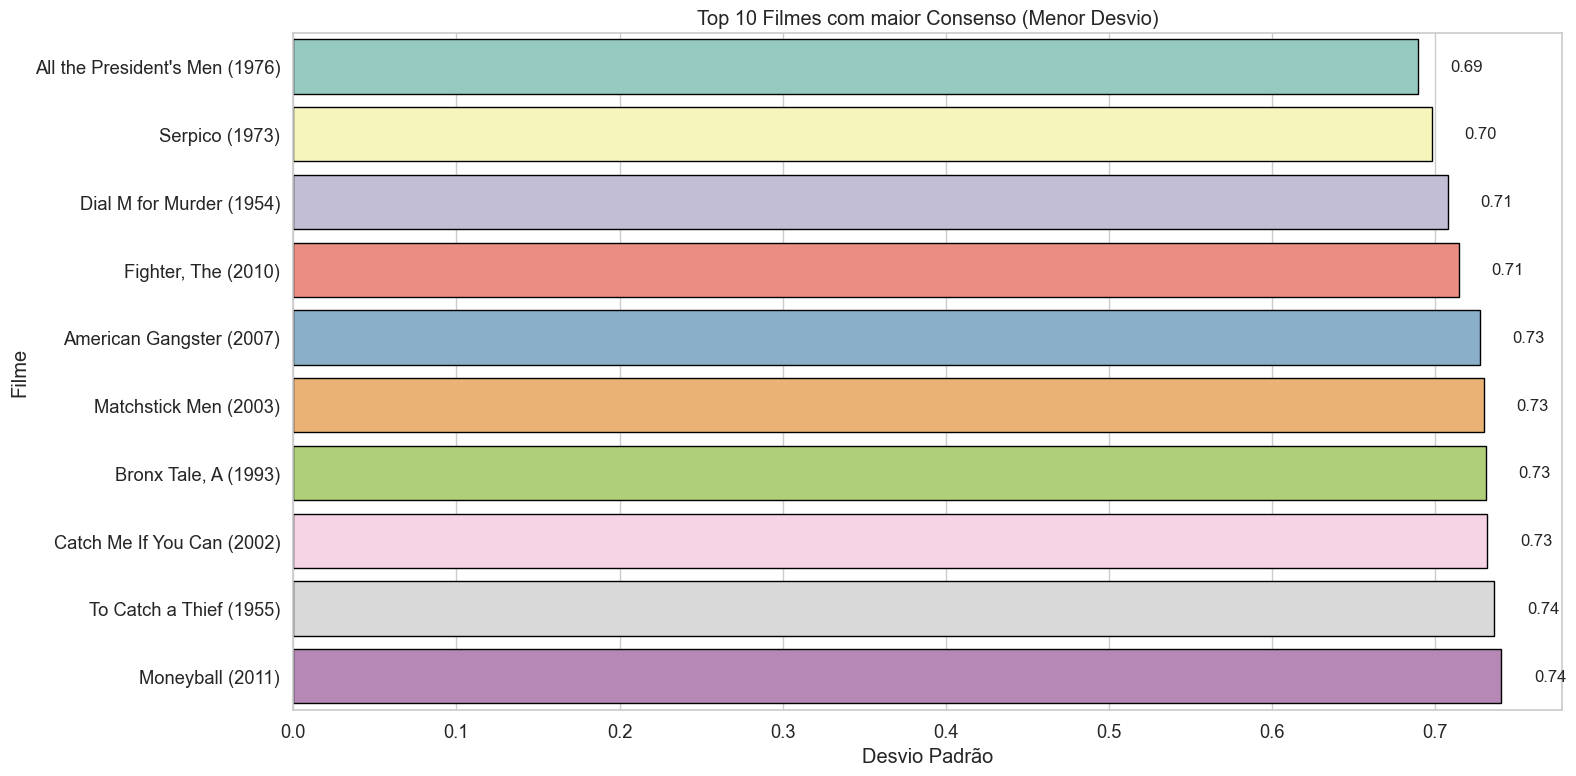

In [136]:
filme_var = (
    ratings.groupby('movieId')['rating']
    .agg(['mean','std','count'])
    .reset_index()
    .merge(movies[['movieId', 'title']], on='movieId')
)

filme_var = filme_var[filme_var['count'] >= 500]

top_disc = filme_var.sort_values('std', ascending=False).head(10)
top_cons = filme_var.sort_values('std', ascending=True).head(10)

plt.figure(figsize=(16,8))
ax = sns.barplot(data=top_disc, y='title', x='std', edgecolor='black', palette='Set3')
plt.title("Top 10 Filmes com maior Discordância (Maior Desvio)")
plt.xlabel("Desvio Padrão")
plt.ylabel("Filme")

for i, v in enumerate(top_disc['std']):
    ax.text(v + 0.02, i, f"{v:.2f}", va='center', fontsize=12)

plt.tight_layout()
plt.show()

plt.figure(figsize=(16,8))
ax = sns.barplot(data=top_cons, y='title', x='std', edgecolor='black', palette='Set3')
plt.title("Top 10 Filmes com maior Consenso (Menor Desvio)")
plt.xlabel("Desvio Padrão")
plt.ylabel("Filme")


for i, v in enumerate(top_cons['std']):
    ax.text(v + 0.02, i, f"{v:.2f}", va='center', fontsize=12)

plt.tight_layout()
plt.show()

**8. Como os gêneros se combinam nos filmes mais bem avaliados? Certas combinações (ex.: Drama + Crime) tendem a gerar melhores notas?**

Por quê?
Ajuda produtores, distribuidoras e plataformas a escolher combinações temáticas com maior apelo do público.

C:\Users\Lu762\AppData\Local\Temp\ipykernel_7160\2127662482.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


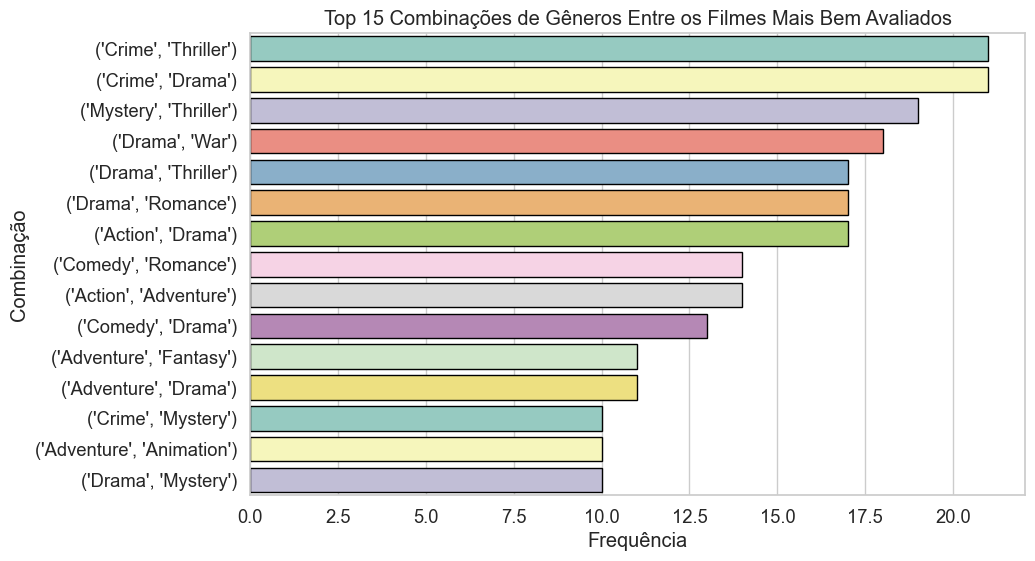

In [141]:
from itertools import combinations
from collections import Counter

filmes_populares = (
    ratings.groupby('movieId')['rating']
    .agg(['mean','count'])
    .reset_index()
)
filmes_populares = filmes_populares[filmes_populares['count'] >= 500]

top_filmes = filmes_populares.sort_values('mean', ascending=False).head(
    int(len(filmes_populares) * 0.10)
)['movieId']

top = movies[movies['movieId'].isin(top_filmes)]

pairs = []
for genres in top['genres']:
    g_list = genres.split('|')
    for combo in combinations(g_list, 2):
        pairs.append(tuple(sorted(combo)))

pair_counts = Counter(pairs).most_common(15)
pair_df = pd.DataFrame(pair_counts, columns=['Combinação','Frequência'])

plt.figure(figsize=(10,6))
sns.barplot(
    data=pair_df,
    y=pair_df['Combinação'].astype(str),
    x='Frequência',
    palette='Set3',
    edgecolor='black'
)
plt.title("Top 15 Combinações de Gêneros Entre os Filmes Mais Bem Avaliados")
plt.xlabel("Frequência")
plt.ylabel("Combinação")
plt.show()
